<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_AdvectionDiffusion_IMEX_CN_GroundTruth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN for 1D Advection–Diffusion (Ground Truth from Crank–Nicolson + Upwind IMEX)

This notebook trains a **Physics-Informed Neural Network (PINN)** for the 1D advection–diffusion PDE on a finite interval:

\[
c_t + u\,c_x = D\,c_{xx},\qquad x\in(0,L),\; t\in[0,T].
\]

We use a **numerical ground truth** generated by an **IMEX scheme**:
- **Advection:** explicit **upwind**
- **Diffusion:** **Crank–Nicolson** (implicit) → tridiagonal solve via **Thomas algorithm**

Then we train a PINN with losses:
- **PDE residual** (physics loss)
- **Initial condition** (IC loss)
- **Dirichlet boundary conditions** (BC loss)
- Optional **supervised data loss** to the numerical ground truth (recommended)

---
## Problem setup (fixed by your inputs)

- **Domain:** \(L=2\)
- **Grid:** \(N=1000\Rightarrow \Delta x = L/N = 0.002\)
- **Constants:** \(u=1\), \(D=\tfrac12\)
- **Initial condition:** \(c(x,0)=x\)
- **Dirichlet BCs:** \(c(0,t)=0\), \(c(L,t)=L=2\)

You can change \(T\) and \(\Delta t\) below (advection CFL applies: \(|u|\Delta t/\Delta x\le 1\)).


In [1]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataclasses import dataclass
from typing import Tuple, Dict

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 1) Parameters

In [2]:
@dataclass
class Params:
    L: float = 2.0
    N: int = 1000
    u: float = 1.0
    D: float = 0.5
    T: float = 0.10          # final time for dataset / training
    dt: float = 1e-3         # IMEX timestep (CFL: u*dt/dx <= 1)
    # PINN settings
    n_f: int = 20000         # collocation points
    n_ic: int = 2000         # IC points
    n_bc: int = 2000         # BC points (total; split between left/right)
    n_data: int = 8000       # supervised data points from numerical solution
    # Training
    epochs: int = 5000
    lr: float = 1e-3
    print_every: int = 250

p = Params()
dx = p.L / p.N
cfl = abs(p.u) * p.dt / dx
mu = p.D * p.dt / dx**2

print("dx =", dx)
print("CFL = u*dt/dx =", cfl)
print("mu = D*dt/dx^2 =", mu)
assert cfl <= 1.0 + 1e-12, "CFL condition violated for explicit upwind advection. Reduce dt."


dx = 0.002
CFL = u*dt/dx = 0.5
mu = D*dt/dx^2 = 125.00000000000001


## 2) Ground truth solver: IMEX (Upwind + Crank–Nicolson)

We solve for \(c_i^n\) on the grid \(i=0..N\). For \(u>0\), the explicit upwind advection term is:

\[
A_i^n = \lambda\,(c_i^n - c_{i-1}^n),\qquad \lambda = \frac{u\Delta t}{\Delta x}.
\]

Crank–Nicolson on diffusion gives a tridiagonal system for the interior points \(i=1..N-1\):

\[
-\frac{\mu}{2}c_{i-1}^{n+1} + (1+\mu)c_i^{n+1} -\frac{\mu}{2}c_{i+1}^{n+1}
= (1-\mu)c_i^n + \frac{\mu}{2}(c_{i-1}^n+c_{i+1}^n) - A_i^n
\]

Dirichlet boundary values:
\(c_0^n=g_0(t^n)=0\), \(c_N^n=g_L(t^n)=L\).


In [3]:
def thomas_solve(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    """Solve tridiagonal system with Thomas algorithm.

    a: lower diag (len m-1)
    b: main diag  (len m)
    c: upper diag (len m-1)
    d: RHS        (len m)
    returns x (len m)
    """
    m = b.size
    cp = np.zeros(m-1, dtype=float)
    dp = np.zeros(m, dtype=float)

    # forward sweep
    denom = b[0]
    cp[0] = c[0] / denom
    dp[0] = d[0] / denom

    for i in range(1, m-1):
        denom = b[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom

    denom = b[m-1] - a[m-2] * cp[m-2] if m > 1 else b[m-1]
    dp[m-1] = (d[m-1] - (a[m-2] * dp[m-2] if m > 1 else 0.0)) / denom

    # back substitution
    x = np.zeros(m, dtype=float)
    x[m-1] = dp[m-1]
    for i in range(m-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x


def solve_imex_cn_upwind(
    L: float,
    N: int,
    u: float,
    D: float,
    T: float,
    dt: float,
    g0_fn=None,
    gL_fn=None,
    ic_fn=None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """IMEX solver: explicit upwind advection + CN diffusion.

    Returns:
        x: (N+1,)
        t: (Nt+1,)
        C: (Nt+1, N+1) solution snapshots
    """
    dx = L / N
    Nt = int(np.round(T / dt))
    t = np.linspace(0.0, Nt * dt, Nt + 1)
    x = np.linspace(0.0, L, N + 1)

    # Defaults
    if g0_fn is None:
        g0_fn = lambda tt: 0.0
    if gL_fn is None:
        gL_fn = lambda tt: L
    if ic_fn is None:
        ic_fn = lambda xx: xx  # c(x,0)=x

    lam = u * dt / dx
    mu = D * dt / dx**2

    # Initialize
    C = np.zeros((Nt + 1, N + 1), dtype=float)
    C[0, :] = ic_fn(x)
    C[0, 0] = g0_fn(0.0)
    C[0, -1] = gL_fn(0.0)

    # Pre-build constant tridiagonal coefficients for interior (size m=N-1)
    m = N - 1
    a = (-mu / 2.0) * np.ones(m - 1)     # lower
    b = (1.0 + mu) * np.ones(m)          # main
    c = (-mu / 2.0) * np.ones(m - 1)     # upper

    for n in range(0, Nt):
        tn = t[n]
        tnp1 = t[n+1]

        # Apply Dirichlet at time n (already true for C[n], but keep consistent)
        C[n, 0] = g0_fn(tn)
        C[n, -1] = gL_fn(tn)

        # RHS for interior i=1..N-1
        rhs = np.zeros(m, dtype=float)
        # Explicit upwind advection term A_i^n
        if u >= 0:
            # A_i^n = lam * (c_i^n - c_{i-1}^n)
            A = lam * (C[n, 1:N] - C[n, 0:N-1])
        else:
            # u<0: right upwind A_i^n = lam * (c_{i+1}^n - c_i^n)
            A = lam * (C[n, 2:N+1] - C[n, 1:N])

        rhs[:] = (1.0 - mu) * C[n, 1:N] + (mu / 2.0) * (C[n, 0:N-1] + C[n, 2:N+1]) - A

        # Dirichlet at time n+1 enters RHS:
        c0_np1 = g0_fn(tnp1)
        cL_np1 = gL_fn(tnp1)
        rhs[0]     += (mu / 2.0) * c0_np1
        rhs[m-1]   += (mu / 2.0) * cL_np1

        interior = thomas_solve(a, b, c, rhs)

        # Write step n+1
        C[n+1, 0] = c0_np1
        C[n+1, 1:N] = interior
        C[n+1, -1] = cL_np1

    return x, t, C


# Generate ground truth
x, t, C = solve_imex_cn_upwind(
    L=p.L, N=p.N, u=p.u, D=p.D, T=p.T, dt=p.dt,
    g0_fn=lambda tt: 0.0,
    gL_fn=lambda tt: p.L,
    ic_fn=lambda xx: xx
)

x.shape, t.shape, C.shape


((1001,), (101,), (101, 1001))

### Quick sanity plot

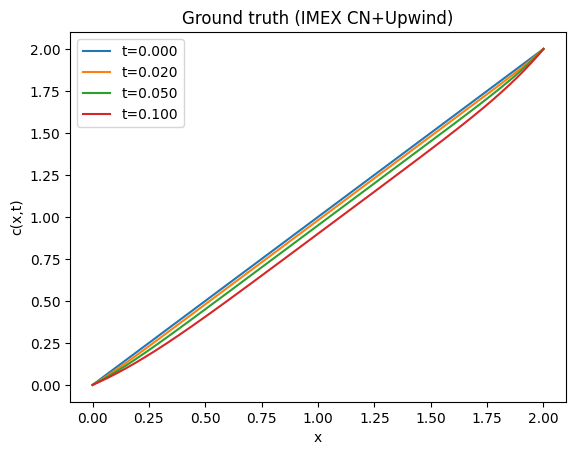

In [4]:
# Plot a few time slices
plt.figure()
for tt in [0.0, 0.02, 0.05, 0.1]:
    idx = int(round(tt / p.dt))
    plt.plot(x, C[idx], label=f"t={t[idx]:.3f}")
plt.xlabel("x")
plt.ylabel("c(x,t)")
plt.legend()
plt.title("Ground truth (IMEX CN+Upwind)")
plt.show()


## 3) Build training datasets (IC, BC, collocation, and supervised data)

We sample points for:
- **IC:** \(t=0\), \(c(x,0)=x\)
- **BC:** \(x=0\Rightarrow c=0\), \(x=L\Rightarrow c=L\)
- **Collocation:** interior points \(x\in(0,L), t\in(0,T]\) for PDE residual
- **Data points:** random samples from the numerical solution \(C\) to anchor the PINN


In [5]:
def sample_ic(n: int, L: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x = np.random.rand(n) * L
    t = np.zeros_like(x)
    c = x.copy()  # c(x,0)=x
    return x, t, c

def sample_bc(n: int, L: float, T: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Split between left and right boundaries
    nL = n // 2
    nR = n - nL

    tL = np.random.rand(nL) * T
    xL = np.zeros_like(tL)
    cL = np.zeros_like(tL)  # c(0,t)=0

    tR = np.random.rand(nR) * T
    xR = np.ones_like(tR) * L
    cR = np.ones_like(tR) * L  # c(L,t)=L

    x = np.concatenate([xL, xR])
    tt = np.concatenate([tL, tR])
    c = np.concatenate([cL, cR])
    return x, tt, c

def sample_collocation(n: int, L: float, T: float) -> Tuple[np.ndarray, np.ndarray]:
    x = np.random.rand(n) * L
    tt = np.random.rand(n) * T
    return x, tt

def sample_data_from_grid(n: int, xgrid: np.ndarray, tgrid: np.ndarray, Cgrid: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Randomly sample indices from the full grid
    Nt = tgrid.size
    Nx = xgrid.size
    tidx = np.random.randint(0, Nt, size=n)
    xidx = np.random.randint(0, Nx, size=n)
    xs = xgrid[xidx]
    ts = tgrid[tidx]
    cs = Cgrid[tidx, xidx]
    return xs, ts, cs

# Create samples
x_ic, t_ic, c_ic = sample_ic(p.n_ic, p.L)
x_bc, t_bc, c_bc = sample_bc(p.n_bc, p.L, p.T)
x_f,  t_f        = sample_collocation(p.n_f, p.L, p.T)
x_d,  t_d,  c_d  = sample_data_from_grid(p.n_data, x, t, C)

# Convert to torch tensors
def to_torch(a: np.ndarray) -> torch.Tensor:
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1, 1)

X_ic = torch.cat([to_torch(x_ic), to_torch(t_ic)], dim=1)
Y_ic = to_torch(c_ic)

X_bc = torch.cat([to_torch(x_bc), to_torch(t_bc)], dim=1)
Y_bc = to_torch(c_bc)

X_f = torch.cat([to_torch(x_f), to_torch(t_f)], dim=1)

X_d = torch.cat([to_torch(x_d), to_torch(t_d)], dim=1)
Y_d = to_torch(c_d)

X_ic.shape, X_bc.shape, X_f.shape, X_d.shape


(torch.Size([2000, 2]),
 torch.Size([2000, 2]),
 torch.Size([20000, 2]),
 torch.Size([8000, 2]))

## 4) PINN model (PyTorch)

We approximate \(c_\theta(x,t)\) with an MLP. PDE residual uses autodiff:

\[
\mathcal{R}(x,t) = c_t + u c_x - D c_{xx}.
\]


In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=128, depth=5, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = MLP(width=128, depth=6).to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [7]:
def pde_residual(model: nn.Module, X: torch.Tensor, u: float, D: float) -> torch.Tensor:
    """Compute PDE residual: c_t + u c_x - D c_xx."""
    X = X.clone().requires_grad_(True)
    c = model(X)  # (n,1)

    grads = torch.autograd.grad(
        outputs=c,
        inputs=X,
        grad_outputs=torch.ones_like(c),
        create_graph=True,
        retain_graph=True,
    )[0]
    c_x = grads[:, 0:1]
    c_t = grads[:, 1:2]

    c_xx = torch.autograd.grad(
        outputs=c_x,
        inputs=X,
        grad_outputs=torch.ones_like(c_x),
        create_graph=True,
        retain_graph=True,
    )[0][:, 0:1]

    r = c_t + u * c_x - D * c_xx
    return r


## 5) Training loop

Loss terms:
- \(\mathcal{L}_f\): PDE residual MSE at collocation points
- \(\mathcal{L}_{ic}\): IC MSE at \(t=0\)
- \(\mathcal{L}_{bc}\): BC MSE at \(x=0\) and \(x=L\)
- \(\mathcal{L}_{data}\): supervised MSE vs. numerical ground truth

You can adjust weights to emphasize physics vs. data.


In [8]:
# Loss weights (tweakable)
w_f = 1.0
w_ic = 10.0
w_bc = 10.0
w_data = 1.0

opt = torch.optim.Adam(model.parameters(), lr=p.lr)

loss_hist = []

for epoch in range(1, p.epochs + 1):
    model.train()
    opt.zero_grad()

    # Predictions
    pred_ic = model(X_ic)
    pred_bc = model(X_bc)
    pred_d  = model(X_d)

    # Losses
    loss_ic = torch.mean((pred_ic - Y_ic) ** 2)
    loss_bc = torch.mean((pred_bc - Y_bc) ** 2)
    loss_d  = torch.mean((pred_d  - Y_d)  ** 2)

    r = pde_residual(model, X_f, p.u, p.D)
    loss_f = torch.mean(r ** 2)

    loss = w_f*loss_f + w_ic*loss_ic + w_bc*loss_bc + w_data*loss_d
    loss.backward()
    opt.step()

    loss_hist.append([loss.item(), loss_f.item(), loss_ic.item(), loss_bc.item(), loss_d.item()])

    if epoch % p.print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | total {loss.item():.3e} | f {loss_f.item():.3e} | ic {loss_ic.item():.3e} | bc {loss_bc.item():.3e} | data {loss_d.item():.3e}")


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch     1 | total 3.928e+01 | f 1.716e-04 | ic 1.531e+00 | bc 2.255e+00 | data 1.420e+00
Epoch   250 | total 3.486e-02 | f 1.702e-03 | ic 1.096e-03 | bc 2.111e-03 | data 1.094e-03
Epoch   500 | total 1.194e-02 | f 8.009e-04 | ic 2.899e-04 | bc 8.086e-04 | data 1.490e-04
Epoch   750 | total 1.188e-02 | f 7.559e-04 | ic 2.928e-04 | bc 8.049e-04 | data 1.496e-04
Epoch  1000 | total 1.478e-02 | f 8.645e-04 | ic 3.846e-04 | bc 9.778e-04 | data 2.910e-04
Epoch  1250 | total 1.178e-02 | f 6.225e-04 | ic 3.021e-04 | bc 7.984e-04 | data 1.524e-04
Epoch  1500 | total 1.177e-02 | f 6.330e-04 | ic 3.022e-04 | bc 7.964e-04 | data 1.527e-04
Epoch  1750 | total 1.176e-02 | f 6.427e-04 | ic 3.003e-04 | bc 7.963e-04 | data 1.522e-04
Epoch  2000 | total 1.176e-02 | f 6.875e-04 | ic 3.115e-04 | bc 7.797e-04 | data 1.569e-04
Epoch  2250 | total 1.176e-02 | f 7.604e-04 | ic 3.019e-04 | bc 7.828e-04 | data 1.537e-04
Epoch  2500 | total 2.141e-02 | f 6.092e-04 | ic 9.787e-05 | bc 1.965e-03 | data 1.715e-04

## 6) Evaluate PINN vs. ground truth on the full grid

In [9]:
# Evaluate on full grid (may take a moment; uses batching)
model.eval()

Xg = np.stack(np.meshgrid(x, t, indexing="xy"), axis=-1)  # shape (Nt+1, Nx, 2)
Xt = torch.tensor(Xg.reshape(-1, 2), dtype=torch.float32, device=device)

batch = 200000  # adjust if GPU/CPU memory is tight
pred_list = []
with torch.no_grad():
    for i in range(0, Xt.shape[0], batch):
        pred_list.append(model(Xt[i:i+batch]).detach().cpu().numpy())
pred = np.concatenate(pred_list, axis=0).reshape(t.size, x.size)

# Error metrics
err = pred - C
l2_rel = np.linalg.norm(err.ravel()) / np.linalg.norm(C.ravel())
mae = np.mean(np.abs(err))
print("Relative L2 error:", l2_rel)
print("MAE:", mae)


Relative L2 error: 0.010865141811788236
MAE: 0.009561557359586055


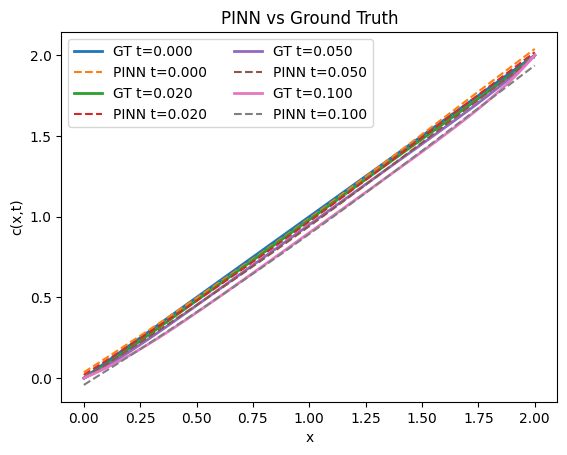

In [10]:
# Plot time slices comparing GT vs PINN
plt.figure()
for tt in [0.0, 0.02, 0.05, 0.1]:
    idx = int(round(tt / p.dt))
    plt.plot(x, C[idx], label=f"GT t={t[idx]:.3f}", linewidth=2)
    plt.plot(x, pred[idx], "--", label=f"PINN t={t[idx]:.3f}")
plt.xlabel("x")
plt.ylabel("c(x,t)")
plt.legend(ncol=2)
plt.title("PINN vs Ground Truth")
plt.show()


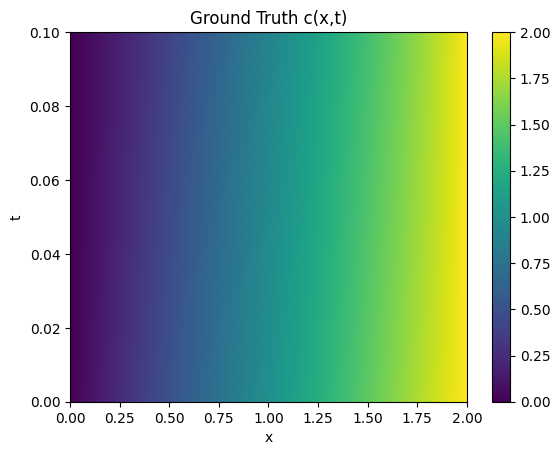

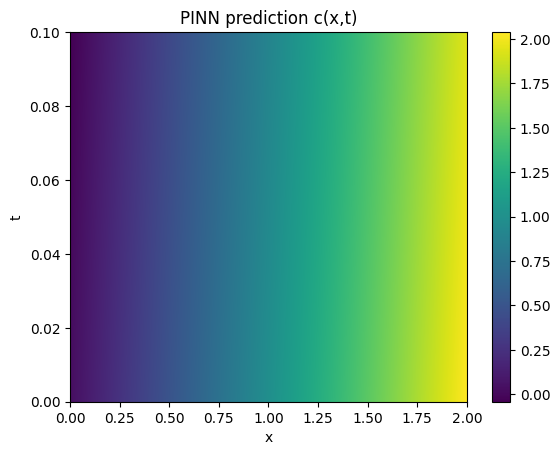

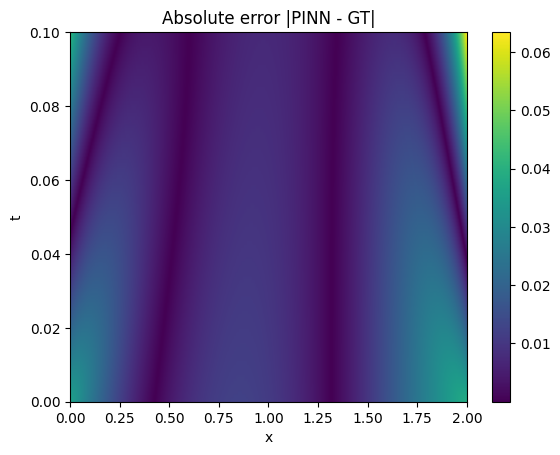

In [11]:
# Heatmaps: GT, PINN, absolute error
def heatmap(Z, title):
    plt.figure()
    plt.imshow(Z, aspect="auto", origin="lower", extent=[0, p.L, 0, p.T])
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title(title)
    plt.colorbar()
    plt.show()

heatmap(C, "Ground Truth c(x,t)")
heatmap(pred, "PINN prediction c(x,t)")
heatmap(np.abs(err), "Absolute error |PINN - GT|")


## 7) Training curves

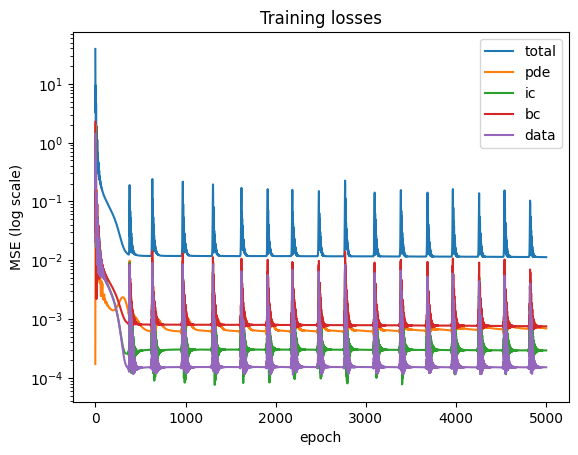

In [12]:
loss_hist = np.array(loss_hist)
plt.figure()
plt.semilogy(loss_hist[:,0], label="total")
plt.semilogy(loss_hist[:,1], label="pde")
plt.semilogy(loss_hist[:,2], label="ic")
plt.semilogy(loss_hist[:,3], label="bc")
plt.semilogy(loss_hist[:,4], label="data")
plt.xlabel("epoch")
plt.ylabel("MSE (log scale)")
plt.title("Training losses")
plt.legend()
plt.show()


## Notes / Tips

- If you want a **pure PINN** (no supervised data), set `w_data=0` and maybe increase `w_f`.
- If the solution is smooth and you trust the numerical method, a small `w_data` helps convergence.
- For faster training:
  - Reduce `n_f` / `n_data`
  - Reduce network width/depth
  - Lower `T` or use coarser grid for the ground truth (you can always re-generate later).
- For higher accuracy:
  - Increase collocation points and epochs
  - Switch optimizer to LBFGS after Adam (optional)
